<a href="https://colab.research.google.com/github/edsonportosilva/OpticalCommunications/blob/main/jupyter notebooks/8. Introdução às comunicações ópticas coerentes.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
if 'google.colab' in str(get_ipython()):    
    ! git clone -b main https://github.com/edsonportosilva/OptiCommPy
    from os import chdir as cd
    cd('/content/OptiCommPy/')
    ! pip install .

In [4]:
import matplotlib.pyplot as plt
import numpy as np
from sympy import Matrix, zeros
from numpy.random import normal
from optic.dsp.core import firFilter, pulseShape, lowPassFIR, symbolSync, pnorm, upsample
from optic.comm.metrics import signal_power
from optic.plot import eyediagram, pconst
from optic.dsp.equalization import edc, mimoAdaptEqualizer
from optic.dsp.carrierRecovery import cpr, fourthPowerFOE
from optic.models.devices import mzm, iqm, edfa, coherentReceiver
from optic.models.channels import linearFiberChannel, ssfm
from optic.utils import parameters

from numpy.fft import fft, ifft, fftshift, ifftshift, fftfreq
from tqdm.notebook import tqdm
from scipy import signal
import scipy.constants as const
import numba

In [5]:
from IPython.core.display import HTML
from IPython.core.pylabtools import figsize
from IPython.display import display, Math

HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

In [6]:
%matplotlib inline
#figsize(7, 2.5)
figsize(10, 3)

In [7]:
import sympy as sp
from utils import symdisp, symplot

In [8]:
%load_ext autoreload
%autoreload 2

# Introduction to Optical communications Coherent

<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Por-que-comunicações-ópticas-coerentes?" data-toc-modified-id="Por-que-comunicações-ópticas-coerentes?-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Por que comunicações ópticas coerentes?</a></span></li><li><span><a href="#Transmissão-de-formatos-de-modulação-coerentes" data-toc-modified-id="Transmissão-de-formatos-de-modulação-coerentes-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Transmissão de formatos de modulação coerentes</a></span></li><li><span><a href="#Detecção-coerente-de-sinais-ópticos" data-toc-modified-id="Detecção-coerente-de-sinais-ópticos-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Detecção coerente de sinais ópticos</a></span><ul class="toc-item"><li><span><a href="#Receptor-IM/DD" data-toc-modified-id="Receptor-IM/DD-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Receptor IM/DD</a></span></li><li><span><a href="#Receptor-coerente" data-toc-modified-id="Receptor-coerente-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Receptor coerente</a></span></li></ul></li><li><span><a href="#Batimento-entre-sinal-e-laser-oscilador-local-(LO)" data-toc-modified-id="Batimento-entre-sinal-e-laser-oscilador-local-(LO)-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Batimento entre sinal e laser oscilador local (LO)</a></span><ul class="toc-item"><li><span><a href="#Batimentos-entre-um-sinal-e-um-oscilador-local" data-toc-modified-id="Batimentos-entre-um-sinal-e-um-oscilador-local-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Batimentos entre um sinal e um oscilador local</a></span></li><li><span><a href="#Potência-do-sinal-detectado-$s(t)$" data-toc-modified-id="Potência-do-sinal-detectado-$s(t)$-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Potência do sinal detectado $s(t)$</a></span></li></ul></li><li><span><a href="#Híbrida-$2\times-4$-90°" data-toc-modified-id="Híbrida-$2\times-4$-90°-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Híbrida $2\times 4$ 90°</a></span><ul class="toc-item"><li><span><a href="#Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida" data-toc-modified-id="Exemplo-de-um-circuito-fotônico-que-implementa-uma-híbrida-5.1"><span class="toc-item-num">5.1&nbsp;&nbsp;</span>Exemplo de um circuito fotônico que implementa uma híbrida</a></span></li><li><span><a href="#Matriz-de-transferência-entrada-saída" data-toc-modified-id="Matriz-de-transferência-entrada-saída-5.2"><span class="toc-item-num">5.2&nbsp;&nbsp;</span>Matriz de transferência entrada-saída</a></span></li><li><span><a href="#Derivação-das-expressões-para-o-front-end-coerente" data-toc-modified-id="Derivação-das-expressões-para-o-front-end-coerente-5.3"><span class="toc-item-num">5.3&nbsp;&nbsp;</span>Derivação das expressões para o front-end coerente</a></span></li><li><span><a href="#Tipos-de-detecção-óptica-coerente" data-toc-modified-id="Tipos-de-detecção-óptica-coerente-5.4"><span class="toc-item-num">5.4&nbsp;&nbsp;</span>Tipos de detecção óptica coerente</a></span></li></ul></li><li><span><a href="#Ruído-de-fase" data-toc-modified-id="Ruído-de-fase-6"><span class="toc-item-num">6&nbsp;&nbsp;</span>Ruído de fase</a></span><ul class="toc-item"><li><span><a href="#Origens" data-toc-modified-id="Origens-6.1"><span class="toc-item-num">6.1&nbsp;&nbsp;</span>Origens</a></span></li><li><span><a href="#Modelo-matemático-para-um-laser-com-perfil-Lorentziano" data-toc-modified-id="Modelo-matemático-para-um-laser-com-perfil-Lorentziano-6.2"><span class="toc-item-num">6.2&nbsp;&nbsp;</span>Modelo matemático para um laser com perfil Lorentziano</a></span></li><li><span><a href="#Modelo-discreto-para-a-evolução-do-ruído-de-fase" data-toc-modified-id="Modelo-discreto-para-a-evolução-do-ruído-de-fase-6.3"><span class="toc-item-num">6.3&nbsp;&nbsp;</span>Modelo discreto para a evolução do ruído de fase</a></span></li></ul></li><li><span><a href="#Exemplo:-detecção-coerente-de-um-laser-não-modulado" data-toc-modified-id="Exemplo:-detecção-coerente-de-um-laser-não-modulado-7"><span class="toc-item-num">7&nbsp;&nbsp;</span>Exemplo: detecção coerente de um laser não-modulado</a></span></li><li><span><a href="#Transmissão-óptica-coerente" data-toc-modified-id="Transmissão-óptica-coerente-8"><span class="toc-item-num">8&nbsp;&nbsp;</span>Transmissão óptica coerente</a></span><ul class="toc-item"><li><span><a href="#Exemplo:-simulação-10G-OOK-vs-10G-BPSK" data-toc-modified-id="Exemplo:-simulação-10G-OOK-vs-10G-BPSK-8.1"><span class="toc-item-num">8.1&nbsp;&nbsp;</span>Exemplo: simulação 10G OOK vs 10G BPSK</a></span></li><li><span><a href="#Exemplo:-simulação-com-formatos-QPSK,-QAM" data-toc-modified-id="Exemplo:-simulação-com-formatos-QPSK,-QAM-8.2"><span class="toc-item-num">8.2&nbsp;&nbsp;</span>Exemplo: simulação com formatos QPSK, QAM</a></span></li></ul></li><li><span><a href="#Multiplexação-de-polarização" data-toc-modified-id="Multiplexação-de-polarização-9"><span class="toc-item-num">9&nbsp;&nbsp;</span>Multiplexação de polarização</a></span></li><li><span><a href="#Sistemas-WDM-coerentes" data-toc-modified-id="Sistemas-WDM-coerentes-10"><span class="toc-item-num">10&nbsp;&nbsp;</span>Sistemas WDM coerentes</a></span></li></ul></div>

## Por que optical communications coherent?

* Receivers com melhor sensitividade.

* Laser sintonizáveis podem ser utilizados para detecção coherent em systems WDM.

* Possibilidade de compensação via DSP de efeitos distorcivos do channel optical (dispersion cromática, PMD, etc).

* Uso de techniques avançadas de modulation e codificação.

* Greater eficiência no uso do spectrum disponível na fibra.

## Transmissão de formatos de modulation coherent

<img src="./figuras/Tx_IQM.png" width="400">

## Detecção coherent de signals optical

### Receiver IM/DD
<img src="./figuras/Rx_OOK.png" width="400">

### Receiver coherent
<img src="./figuras/hibrida_4x90.png" width="650">

In [9]:
t, ω_c, ω_lo, ϕ_lo, Δω, Δϕ = sp.symbols('t, ω_c, ω_{LO}, ϕ_{LO}, Δω, Δϕ', real=True)
P_s, P_lo, R = sp.symbols('P_s, P_{LO}, R_d', real=True, positive=True)

A = sp.Function('A', real=True)(t)
ϕ = sp.Function('ϕ', real=True)(t)

π = sp.pi
j = sp.I

**Electric field da portadora optical modulada $E_s(t)$**

In [10]:
E_s = sp.sqrt(P_s)*A*sp.exp(j*(ω_c*t + ϕ))

symdisp('E_s(t) =', E_s)

<IPython.core.display.Math object>

**Electric field do laser oscilador local $E_{LO}(t)$**

In [11]:
E_lo = sp.sqrt(P_lo)*sp.exp(j*(ω_lo*t + ϕ_lo))

symdisp('E_{LO}(t) =', E_lo)

<IPython.core.display.Math object>

## Batimento entre signal e laser oscilador local (LO)

$$
\begin{aligned}
I_1(t) &= R_d\left|E_s(t) + jE_{LO}(t) \right|^2 \nonumber\\
       &= R_d\left[E_s(t) + jE_{LO}(t) \right]\left[E_s^*(t) - jE_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[E_s(t)E_s^*(t) + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) -j^2E_{LO}(t)E_{LO}^*(t) \right] \nonumber\\
       &= R_d\left[A^2P_s + jE_{LO}(t)E_s^*(t) - jE_s(t)E_{LO}^*(t) + P_{LO}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d\left[ jE_{LO}(t)E_s^*(t) +(jE_{LO}(t)E_s^*(t))^* \right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + R_d 2\operatorname{Re}\left[jE_{LO}(t)E_s^*(t)\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_d\operatorname{Re}\left[j\sqrt{P_{LO}}e^{j(ω_{LO}t + ϕ_{LO})}A\sqrt{P_{s}}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[je^{j(ω_{LO}t + ϕ_{LO})}e^{-j(ω_ct + ϕ)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{Re}\left[e^{j(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2)}\right] \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\cos(ω_{LO}t -ω_ct + ϕ_{LO}- ϕ + \pi/2) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] - 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_{LO}t -ω_ct + ϕ_{LO} - ϕ) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(ω_ct - ω_{LO}t + ϕ - ϕ_{LO}) \nonumber\\
       &= R_d\left[A^2P_s + P_{LO}\right] + 2R_dA\sqrt{P_{LO}}\sqrt{P_{s}}\operatorname{sen}(\Delta ωt + \Delta \phi) \nonumber\\
\end{aligned}
$$

em que $\Delta \omega = \omega_c - \omega_{LO}$ e $\Delta \phi = \phi - \phi_{LO}$.

### Batimentos entre um signal e um oscilador local

**Fotocorrente $i_1(t)\propto |E_s + jE_{LO}|^2$**

In [12]:
Ei1 = (E_s + j*E_lo)/2

symdisp('E_{i_1}(t) =', Ei1)

i1 = R*sp.Abs(Ei1)**2

i1 = sp.re(i1).simplify().expand()

symdisp('i_1(t) =', i1)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_2(t) \propto |E_s - jE_{LO}|^2$**

In [13]:
Ei2 = (E_s - j*E_lo)/2

symdisp('E_{i_2}(t) =', Ei2)

i2 = R*sp.Abs(Ei2)**2

i2 = sp.re(i2).simplify().expand()

symdisp('i_2(t) =', i2)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_Q(t) = i_1(t)-i_2(t)$**

In [14]:
sQ = i1 - i2 # output do fotodetector balanceado

sQ = sQ.simplify()

symdisp('s_Q(t) =', sQ)

<IPython.core.display.Math object>

**Fotocorrente $i_3(t) \propto |E_s + E_{LO}|^2$**

In [15]:
Ei3 = (E_s + E_lo)/2

symdisp('E_{i_3}(t) =', Ei3)

i3 = R*sp.Abs(Ei3)**2

i3 = sp.re(i3).simplify().expand()

symdisp('i_3(t) =', i3)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Fotocorrente $i_4(t) \propto |E_s - E_{LO}|^2$**

In [16]:
Ei4 = (E_s - E_lo)/2

symdisp('E_{i_4}(t) =', Ei4)

i4 = R*sp.Abs(Ei4)**2

i4 = sp.re(i4).simplify().expand()

symdisp('i_4(t) =', i4)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Corrente $s_I(t) = i_3(t)-i_4(t)$**

In [17]:
sI = i3 - i4 # output do fotodetector balanceado

sI = sI.simplify()

symdisp('s_I(t) =', sI)

<IPython.core.display.Math object>

**Signal complex detectado $s(t) = s_I(t) + js_Q(t)$**

In [18]:
s = sI + j*sQ

s = s.simplify()

symdisp('s(t) =', s)

<IPython.core.display.Math object>

### Power do signal detectado $s(t)$

In [19]:
Pr = sp.Abs(s)**2 # power do signal s(t)

symdisp('P_r(t) =', Pr)

<IPython.core.display.Math object>

## Híbrida $2\times 4$ 90°

### Example de um circuito fotônico que implementa uma híbrida

<img src="./figuras/hibrida_PIC.png" width="400">

### Matrix de transferência input-output

$$M=\left[\begin{array}{cccc}\frac{\sqrt{2}}{2} & \frac{\sqrt{2} j}{2} & 0 & 0 \\ \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2} & 0 & 0 \\ 0 & 0 & \frac{\sqrt{2}}{2} & \frac{\sqrt{2 j}}{2} \\ 0 & 0 & \frac{\sqrt{2} j}{2} & \frac{\sqrt{2}}{2}\end{array}\right]$$

$$
U=\left[\begin{array}{llll}
1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & i
\end{array}\right]
$$

$$ T = MUM $$

### Derivação das expressões para o front-end coherent

**Matrix de transferência do acoplador 3dB**

In [20]:
C_3dB  = 1/sp.sqrt(2)*Matrix([[1, j],[j, 1]])

symdisp('C_{3dB} = ', C_3dB)

<IPython.core.display.Math object>

**Matrix de transferência da híbrida $2\times4$ 90°**

In [21]:
M = Matrix([[C_3dB, zeros(2)], [zeros(2), C_3dB]])
U = Matrix([[1, 0, 0, 0],[0, 0, 1, 0],[0, 1, 0, 0],[0, 0, 0, j]])

symdisp('M = ', M)
symdisp('U = ', U)
symdisp('T = MUM = ', M*U*M)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Derivação das expressões do *front-end* coherent com o Sympy**

In [22]:
# define functions do sympy para auxílio na derivação das expressões

# híbrida
def hybrid_2x4_90(E1, E2):
    
    M = Matrix([[C_3dB, zeros(2)], 
                [zeros(2), C_3dB]])
    
    U = Matrix([[1, 0, 0, 0],
                [0, 0, 1, 0],
                [0, 1, 0, 0],
                [0, 0, 0, j]])
    
    Ei = Matrix([[E1],[0],[0],[E2]]) # vector 4x1
    
    Eo = M*U*M*Ei 
    
    return Eo    

# fotodetector balanceado
def bpd(E1, E2, R=1):
    
    i1 = sp.Abs(E1)**2 # |E1|^2
    i2 = sp.Abs(E2)**2 # |E2|^2
    i = i1 - i2
    
    return R*sp.re(i).simplify().expand()

In [23]:
Eo = hybrid_2x4_90(E_s, E_lo)

print('Entrada óptica da híbrida:')
symdisp('E_i = ', Matrix([[E_s],[0],[0],[E_lo]]))

Entrada óptica da híbrida:


<IPython.core.display.Math object>

In [24]:
print('Saída óptica da híbrida:')
symdisp('E_o = ', Eo)

Saída óptica da híbrida:


<IPython.core.display.Math object>

**Fotodetecção balanceada**

In [25]:
sI = bpd(Eo[1], Eo[0], R) # fotodeteccão balanceada de Eo[1] e Eo[0]
sQ = bpd(Eo[2], Eo[3], R) # fotodeteccão balanceada de Eo[2] e Eo[3]

symdisp('s_I = ', sI)
symdisp('s_Q = ', sQ)

<IPython.core.display.Math object>

<IPython.core.display.Math object>

**Electric field recuperado**

In [26]:
s  = sI + j*sQ
s  = s.simplify()

symdisp('s = ', s)

<IPython.core.display.Math object>

In [27]:
s = s.subs({ω_lo:ω_c + Δω, ϕ:ϕ_lo + Δϕ})

s = s.simplify().doit()

symdisp('s = ', s)

<IPython.core.display.Math object>

### Types de detecção optical coherent

* **Detecção homódina (*homodyne detection*)**($\Delta\omega = 0$): a frequency do laser do transmitter e a frequency do laser oscilador local são idênticas.

* **Detecção heteródina (*heterodyne detection*)**($\Delta\omega \neq 0$): a frequency do laser do transmitter e a frequency do laser oscilador local são diferentes.

* **Detecção intradina (*intradyne detection*)**($\Delta\omega \approx 0$): a frequency do laser do transmitter e do laser oscilador local são "ligeiramente" diferentes.

**Assumindo coerência perfeita entre os lasers do transmitter e do receiver($Δω=0, ϕ_{LO}=0$)**

In [28]:
# assumindo que portadora e oscilador local estão sincronizados em phase e frequency
s = s.subs({Δω:0, Δϕ:ϕ})/(sp.sqrt(P_s)*sp.sqrt(P_lo)*R)

symdisp('s = ', s)

<IPython.core.display.Math object>

**Functions para modelagem de um receiver coherent utilizando o numpy**

In [29]:
def balancedPD(E1, E2, R=1):
    '''
    Balanced photodetector (BPD)
    
    :param E1: input field [nparray]
    :param E2: input field [nparray]
    :param R: photodiode responsivity [scalar]
    
    :return: balanced photocurrent
    '''
    assert R > 0, 'PD responsivity should be a positive scalar'
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    i1 = R*E1*np.conj(E1)
    i2 = R*E2*np.conj(E2)    

    return i1-i2

def hybrid_2x4_90deg(E1, E2):
    '''
    Optical 2 x 4 90° hybrid
    
    :param E1: input signal field [nparray]
    :param E2: input LO field [nparray]
        
    :return: hybrid outputs
    '''
    assert E1.size == E2.size, 'E1 and E2 need to have the same size'
    
    # optical hybrid transfer matrix    
    T = np.array([[ 1/2,  1j/2,  1j/2, -1/2],
                  [ 1j/2, -1/2,  1/2,  1j/2],
                  [ 1j/2,  1/2, -1j/2, -1/2],
                  [-1/2,  1j/2, -1/2,  1j/2]])
    
    Ei = np.array([E1, np.zeros((E1.size,)), 
                   np.zeros((E1.size,)), E2])    
    
    Eo = T@Ei
    
    return Eo
    
def coherentReceiver(Es, Elo, Rd=1):
    '''
    Single polarization coherent optical front-end
    
    :param Es: input signal field [nparray]
    :param Elo: input LO field [nparray]
    :param Rd: photodiode resposivity [scalar]
    
    :return: downconverted signal after balanced detection    
    '''
    assert Rd > 0, 'PD responsivity should be a positive scalar'
    assert Es.size == Elo.size, 'Es and Elo need to have the same size'
    
    # optical 2 x 4 90° hybrid 
    Eo = hybrid_2x4_90deg(Es, Elo)
        
    # balanced photodetection
    sI = balancedPD(Eo[1,:], Eo[0,:], Rd)
    sQ = balancedPD(Eo[2,:], Eo[3,:], Rd)
    
    return sI + 1j*sQ

## Noise de phase

O **noise de phase** de um laser refere-se às flutuações estocásticas na phase da onda optical emitida. Essas flutuações resultam em um alargamento da linha espectral do laser, limitando a sua pureza espectral. Em outras palavras, o noise de phase é responsável pelo **alargamento da largura de linha** do laser, que é a medida da largura espectral da radiação emitida.


### Origens

A origem física do noise de phase está associada a processes quânticos e térmicos dentro do laser. Ele surge principalmente de:

1. **Noise de emissão espontânea**:
   - Durante a optical amplification no meio ativo, ocorre emissão espontânea junto com a emissão estimulada.
   - A emissão espontânea adiciona uma component aleatória ao field optical, contribuindo para flutuações na phase e amplitude.

2. **Flutuações no number de fótons**:
   - Processes quânticos no meio ativo fazem com que o number de fótons no mode laser flutue, afetando a frequency instantânea.

3. **Efeitos térmicos e mecânicos**:
   - Pequenas variações de temperatura ou vibrações podem alterar as propriedades do meio ativo ou da cavidade ressonante, introduzindo mais instabilidades na phase.

A ratio entre essas flutuações e o noise de phase é descrita matematicamente como um **process de difusão na phase**.


### Model matemático para um laser com perfil Lorentziano

Para um laser ideal com perfil espectral **Lorentziano**, o spectrum de power é descrito como:

$$
S(f) = \frac{1}{\pi} \frac{\Delta f / 2}{f^2 + (\Delta f / 2)^2},
$$

onde:
- $\Delta f$ é a **largura de linha** do laser (em Hz),
- $f$ é o desvio de frequency relativo à frequency central.


O noise de phase pode ser modelado como um **process de Wiener**, no qual a phase $\phi(t)$ do laser evolui estocasticamente no time:

$$
\frac{d\phi(t)}{dt} = \Delta f \eta(t),
$$

onde:
- $ \eta(t) $ é um noise branco Gaussiano com média zero e variância unitária,
- $ \Delta f$ está relacionado à rate de difusão da phase.

A phase acumulada é dada por:

$$
\phi(t) = \phi(0) + \sqrt{2 \pi \Delta f} \int_0^t \eta(\tau) \, d\tau,
$$

o que implica que a variância da phase aumenta linearmente com o time.

Para um laser Lorentziano, o desvio quadrático average da phase cresce de acordo com:

$$
\langle (\phi(t) - \phi(0))^2 \rangle = 2 \pi \Delta f t.
$$

### Model discreto para a evolução do noise de phase

No time discreto, o noise de phase pode ser modelado como um process estocástico autoregressivo, no qual a phase $\phi[n]$ evolui ao longo do time. 

Assumindo que a phase $\phi$ é observada periodicamente com um intervalo de amostragem $T_s$, a evolução discreta da phase é dada por:

$$
\phi[n+1] = \phi[n] + \Delta \phi[n],
$$

onde:
- $ \phi[n]$ é a phase no instante $n$,
- $ \Delta \phi[n]$ é o incremento estocástico da phase entre os instantes $n$ e $n+1$.

O incremento $\Delta \phi[n]$ é uma variable aleatória Gaussiana com média zero e variância $\sigma_{\phi}^2$:

$$
\Delta \phi[n] \sim \mathcal{N}(0, \sigma_{\phi}^2),
$$

onde:
- $\sigma_{\phi}^2 = 2 \pi \Delta f T_s$,
- $ \Delta f$ é a largura de linha do laser (em Hz),
- $ T_s $ é o intervalo de amostragem (em segundos)

In [133]:
def phaseNoise(lw, Nsamples, Ts):
    """
    Generate laser phase noise samples.

    Parameters
    ----------
    lw : float
        Laser linewidth (in Hz).
    Nsamples : int
        The number of samples of the phase noise sequence.
    Ts : float
        The sampling interval (in seconds).

    Returns
    -------
    numpy.ndarray
        An array containing the phase noise sequence.

    Notes
    -----
    - The phase noise is modeled as a Wiener process with variance σ² 
      proportional to `2 * π * lw * Ts`.
    - The output `phi` is generated iteratively, where each subsequent 
      phase increment is drawn from a normal distribution with standard
      deviation `sqrt(σ²)`.
  
    """
    
    σ2 = 2*np.pi*lw*Ts    
    phi = np.zeros(Nsamples)
    
    for ind in range(0, Nsamples-1):
        phi[ind+1] = phi[ind] + normal(0, np.sqrt(σ2))
        
    return phi

In [ ]:
def lorentzian(f, f0, delta_f):
    """
    Calcula curva espectral de perfil Lorentziano.

    Parâmetros
    ----------
    f : numpy.ndarray
        Frequências onde o perfil será calculado.
    f0 : float
        Frequência central do perfil (Hz).
    delta_f : float
        Largura de linha do perfil em Hz (FWHM).

    Retorna
    -------
    S : numpy.ndarray
        Valores do perfil Lorentziano para as frequências fornecidas.
    """
    return (1 / np.pi) * (delta_f / 2) / ((f - f0)**2 + (delta_f / 2)**2)

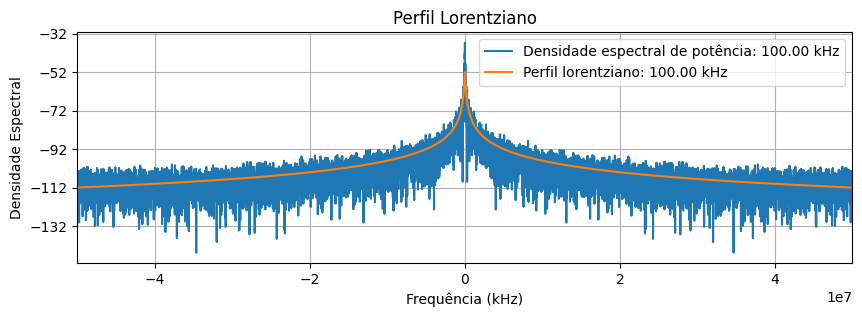

In [146]:
# Parameters of the perfil Lorentziano
f0 = 0      # Frequency central em Hz
lw = 100e3  # Largura de linha em Hz (FWHM)

Fa = 100e6
f = np.linspace(-Fa/2, Fa/2, 100000)  # Intervalo de frequencies em Hz

# Cálculo do perfil Lorentziano
S = lorentzian(f, f0, lw)
S = 10*np.log10(S)

# Gera amostras de noise de phase de acordo com model discreto no time
Nsamples = 10000
fpsd = np.linspace(-Fa/2, Fa/2, Nsamples)  # Intervalo de frequencies em Hz
pn_samples = phaseNoise(lw, Nsamples, 1/Fa)

# Plot o perfil Lorentziano e PSD calculada
plt.psd(pn_samples, Fs=Fa, NFFT = 16*1024, sides='twosided', label=f'Densidade espectral de potência: {lw/1000:.2f} kHz')
plt.legend(loc='upper left');
plt.plot(f, S, label=f'Perfil lorentziano: {lw/1000:.2f} kHz')
plt.title('Perfil Lorentziano')
plt.xlabel('Frequência (kHz)')
plt.ylabel('Densidade Espectral')
plt.grid(True)
plt.legend()
plt.xlim(-Fa/2, Fa/2)
plt.show()

## Example: detecção coherent de um laser não-modulado

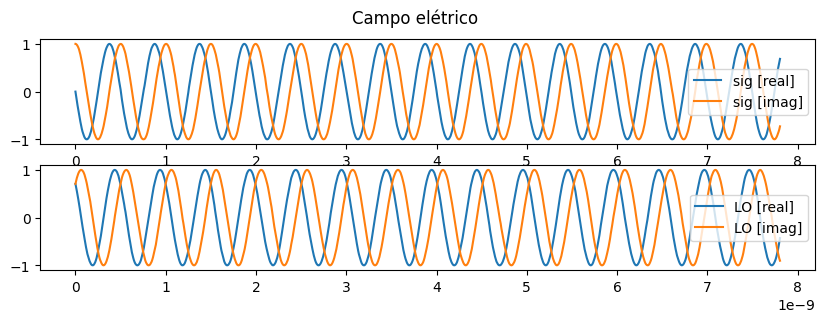

In [29]:
# parameters of the simulation
Fa     = 128e9    # Frequency de amostragem do signal
Ta     = 1/Fa     # Período de amostragem

Nsamples = 1000

#Pi_dBm = 10  # power de signal optical na input do modulador em dBm
π = np.pi

#
lw = 1e6
pn_sig = phaseNoise(lw, Nsamples, Ta)
pn_lo  = phaseNoise(lw, Nsamples, Ta)

# parameters of the signal
Pin   = 1     # power do laser
f_sig = 2e9   # frequency do signal
ϕs    = π/2   # phase do laser

# parameters of the oscilador local
Plo  = 1    # power do oscilador local na input do receiver
f_lo = 2e9  # frequency do oscilador local
ϕ_lo = π/4    # phase do oscilador local

############# Simulation #############

# oscilador local
t     = np.arange(0, Nsamples)*Ta
sig   = np.sqrt(Pin)*np.exp(1j*(2*π*f_sig*t + ϕs + pn_sig))*np.ones(t.size) # electric field do signal
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*f_lo*t + ϕ_lo + pn_lo)) # electric field do oscilador local

fig, axs = plt.subplots(2)
fig.suptitle('Campo elétrico')
axs[0].plot(t, sig.real, label = 'sig [real]')
axs[0].plot(t, sig.imag, label = 'sig [imag]')
axs[0].legend();
axs[1].plot(t, sigLO.real, label = 'LO [real]')
axs[1].plot(t, sigLO.imag, label = 'LO [imag]');
axs[1].legend();

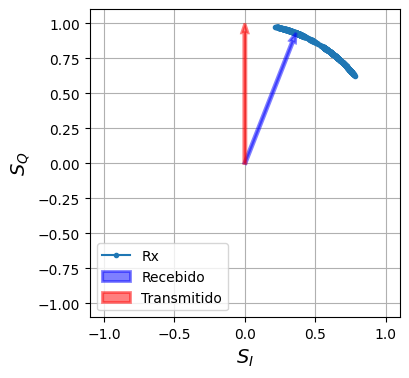

In [30]:
# receiver coherent
sigRx = coherentReceiver(sig, sigLO)

plt.figure(figsize=(4,4))
plt.plot(sigRx.real,sigRx.imag,'o-', markersize=3, label='Rx')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-1.1,1.1)
plt.ylim(-1.1,1.1)
plt.grid()

plt.arrow(0, 0, sigRx[-1].real,sigRx[-1].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'blue', 
                                         facecolor = 'blue', lw = 2, zorder = 5, label='Recebido')

plt.arrow(0, 0, sig[0].real,sig[0].imag, length_includes_head=True, shape ='full',
                                         alpha = 0.5, width = 0.015, edgecolor = 'red', 
                                         facecolor = 'red', lw = 2, zorder = 5, label='Transmitido')
plt.legend(loc='lower left');

## Transmissão optical coherent

<img src="./figuras/sistemaCoerente.png" width="1000">

### Example: simulation 10G OOK vs 10G BPSK

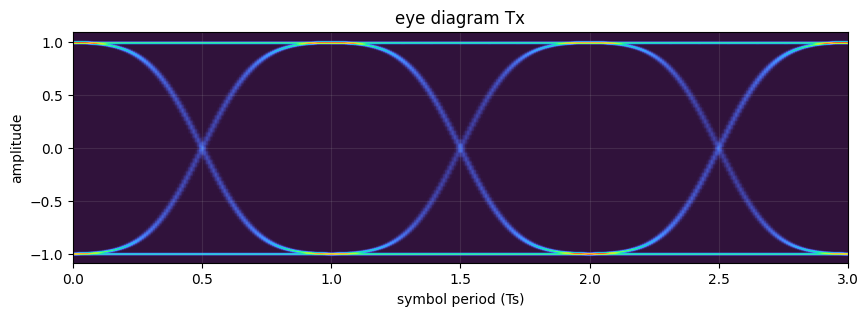

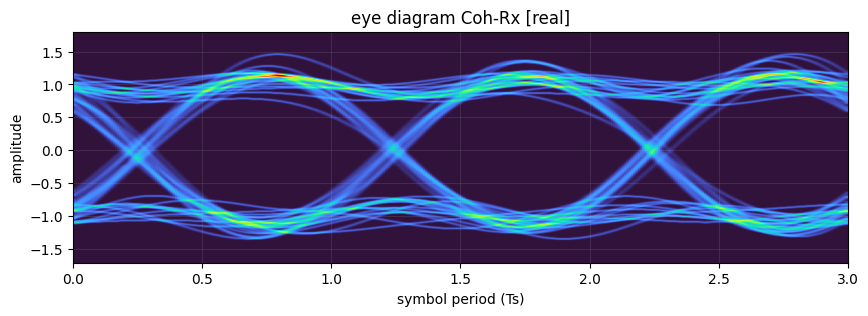

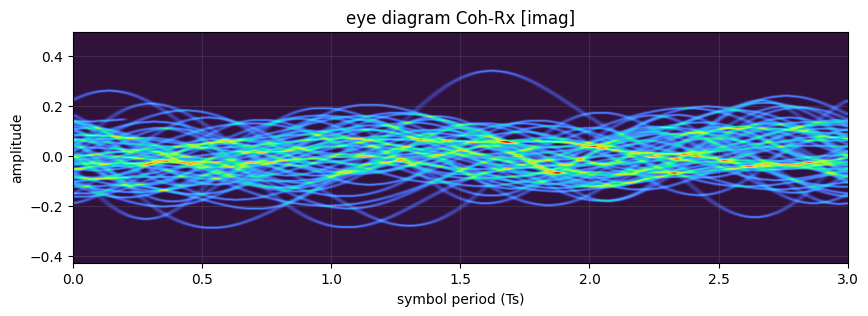

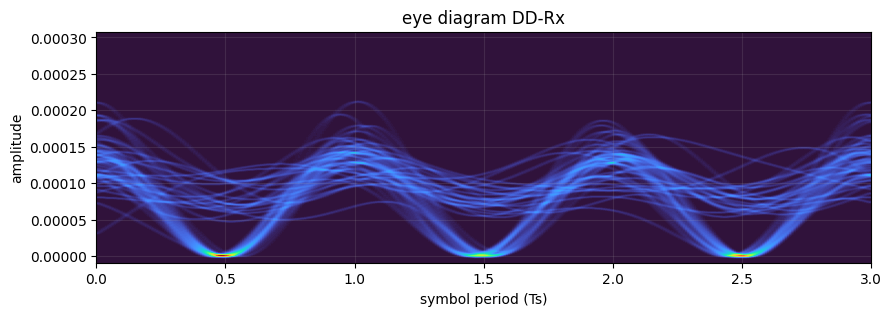

P_sig[opt] = -10.55 dBm
P_ase[opt] = -27.00 dBm
OSNR[est,Bsig] = 16.35 dB 

SNR[est] = 17.41 dB 

Total de erros contados = 0  
BER = 0.00e+00  


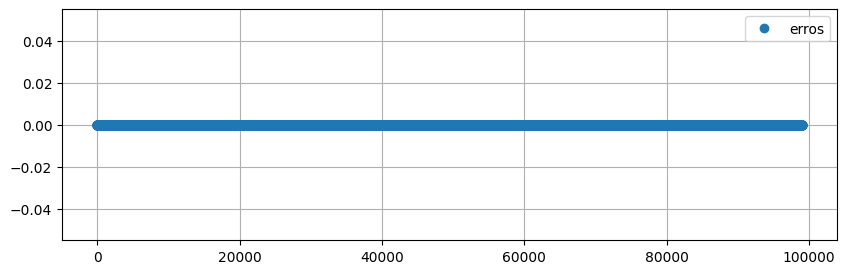

In [31]:
modulation = 'BPSK' # 'OOK', 'BPSK'

# parameters of the simulation
SpS    = 16            # number de amostras por símbolo
Rs     = 10e9          # Symbol rate (para o caso do OOK Rs = Rb)
Ts     = 1/Rs          # Período de símbolo em segundos
Fa     = 1/(Ts/SpS)    # Frequency de amostragem do signal (amostras/second)
Ta     = 1/Fa          # Período de amostragem

π = np.pi

# parameters of the MZM
Vπ = 2

if modulation == 'OOK':
    Vb  = -Vπ/2
    Amp = 1
    Pi_dBm = -10+3.5  # power de signal optical na input do modulador em dBm
elif modulation == 'BPSK':
    Vb = -Vπ
    Amp = 2
    Pi_dBm = -10  # power de signal optical na input do modulador em dBm

    
paramMZM = parameters()
paramMZM.Vpi = Vπ
paramMZM.Vb = Vb

Pi = 10**(Pi_dBm/10)*1e-3 # power de signal optical em W na input do MZM

# parameters of the receiver
B   = 10e9      # banda do receiver em Hz
Plo_dBm  = 10   # power do oscilador local
Δf_lo = 0       # desvio de frequency do oscilador local
ϕ_lo  = 0       # phase do oscilador local

Plo = 10**(Plo_dBm/10)*1e-3 # power do oscilador local na input do receiver


############# Simulation #############

### Transmitter

# gera sequência de bits pseudo-aleatórios
bitsTx = np.random.randint(2, size=100000)    
n      = np.arange(0, bitsTx.size)

# mapeia bits para pulsos elétricos
symbTx = 2*bitsTx-1
symbTx = pnorm(symbTx)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulation optical
Ai      = np.sqrt(Pi)
sigTxo_ = mzm(Ai, Amp*sigTx, paramMZM)

# adiciona noise ASE ao signal optical
σASE  = 1e-6#1e-5
ruido = normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size) + 1j*normal(0, np.sqrt(Fa*(σASE/(2*B))), sigTxo_.size)

sigTxo = sigTxo_ + ruido

### Recepcão coherent
Pin = signal_power(sigTxo) # Power optical média média recebida

# oscilador local
t     = np.arange(0, sigTxo.size)*Ta
sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo))

# receiver coherent
sigRx = coherentReceiver(sigTxo, sigLO)
sigRx = pnorm(sigRx)

# filtragem Rx
N = 8001
h = lowPassFIR(B, Fa, N, typeF='rect')
sigRx = firFilter(h, sigRx)

# calculando a OSNR na simulation
sigTxo_Rx   = firFilter(h, sigTxo_)
sigTxo_DDRx = firFilter(h, sigTxo)
ruido_Rx    = firFilter(h, ruido)

OSNR = signal_power(sigTxo_Rx)/signal_power(ruido_Rx)

Nsamples = 10000

sigEye = sigRx.copy()
eyediagram(sigTx,  len(sigTx), SpS, plotlabel = 'Tx', ptype='fancy')
eyediagram(sigEye[int(h.size/SpS)::], len(sigTx), SpS, plotlabel = 'Coh-Rx', ptype='fancy')
eyediagram(np.abs(sigTxo_DDRx)**2,len(sigTxo_DDRx), SpS, plotlabel = 'DD-Rx', ptype='fancy')

# captura amostras no meio dos intervalos de sinalização
sigRx = sigRx[0::SpS]
sigRx = pnorm(sigRx)

if modulation == 'OOK':
    symbTx = (symbTx+1)/np.sqrt(signal_power(symbTx+1))
    
# Aplica a regra de decisão ótima
bitsRx = np.empty(bitsTx.size)
bitsRx[sigRx> symbTx.mean()] = 1
bitsRx[sigRx<= symbTx.mean()] = 0

discard = 500
ind = np.arange(discard, sigRx.size-discard)

# estima SNR do signal recebido: SNR = Es/σ^2
SNR = 1/signal_power(sigRx[ind]-symbTx[ind])

err = np.logical_xor(bitsRx[ind], 
                     bitsTx[ind])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est,Bsig] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

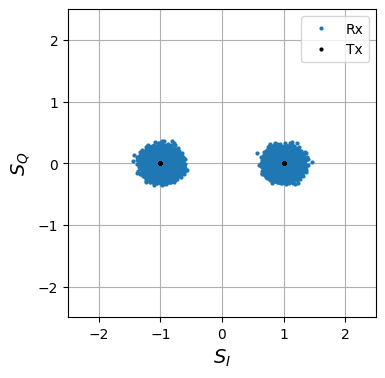

In [32]:
plt.figure(figsize=(4,4))
plt.axis('square')
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
plt.xlim(-2.5, 2.5)
plt.ylim(-2.5, 2.5)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx')
plt.legend();

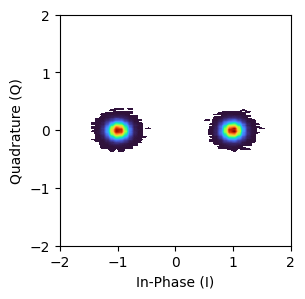

In [33]:
pconst(sigRx, R=2);

### Example: simulation com formatos QPSK, QAM


In [34]:
from optic.comm.modulation import modulateGray, demodulateGray, grayMapping
from optic.dsp.core import pnorm, decimate

P_sig[opt] = -11.32 dBm
P_ase[opt] = -69.04 dBm
OSNR[est] = -46.38 dB 

SNR[est] = 40.83 dB 

Total de erros contados = 0  
BER = 0.00e+00  


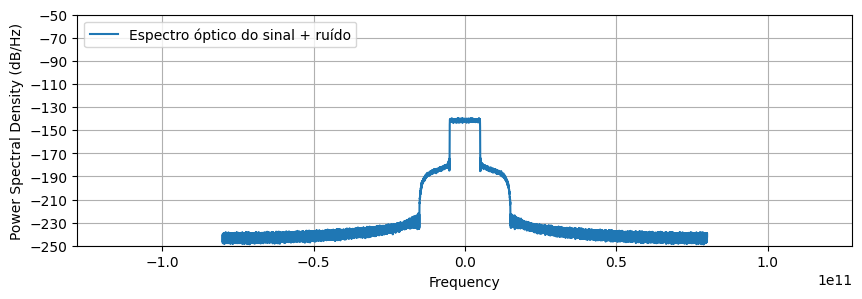

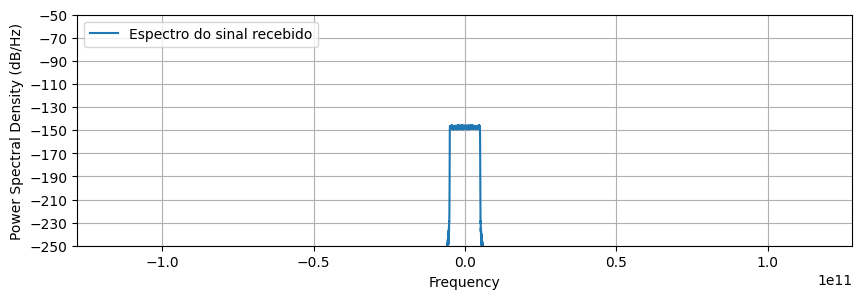

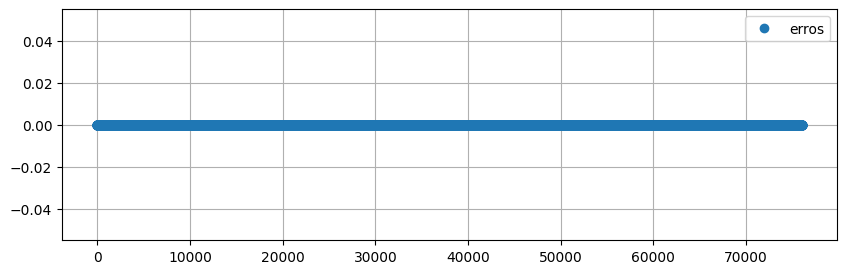

In [35]:
plotEyeDiagrams = False
plotPSD         = True

# parameters of the simulation
M      = 4
SpS    = 16            # number de amostras por símbolo
Rs     = 32e9          # Symbol rate 
Ts     = 1/Rs          # Período de símbolo em segundos
Fs     = SpS*Rs        # Frequency de amostragem do signal (amostras/second)

Pi_dBm = 0  # power de signal optical na input do modulador em dBm
π = np.pi

# parameters of the IQM
paramIQM = parameters()
paramIQM.Vpi = 2
paramIQM.Vb = -paramIQM.Vpi

Pi = 10**(Pi_dBm/10)*1e-3 # power de signal optical em W na input do MZM

# parameters of the channel optical
paramCh = parameters()
paramCh.Ltotal = 20    # km
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.Fs = Fs        

# parameters of the receiver
B  = 32e9     # banda do receiver em Hz

Plo_dBm  = 10    # power do oscilador local
Δf_lo    = 0     # desvio de frequency do oscilador local
ϕ_lo     = 0     # phase do oscilador local
lw       = 0*10e3

Plo = 10**(Plo_dBm/10)*1e-3 # power do oscilador local na input do receiver

############# Simulation #############

### Transmitter

# gera sequência de bits pseudo-aleatórios
bitsTx   = np.random.randint(2, size=80000)    

# mapeia bits para símbolos QAM
symbTx = modulateGray(bitsTx, M, 'qam')

# normaliza energia média dos símbolos para 1
symbTx = pnorm(symbTx)

# upsampling
symbolsUp = upsample(symbTx, SpS)

# pulso
#pulse = pulseShape('nrz', SpS)
pulse = pulseShape('rrc', SpS, N=4096, alpha=0.01, Ts=Ts)
pulse = pulse/np.max(np.abs(pulse))

# formatação de pulso
sigTx  = firFilter(pulse, symbolsUp)

# modulation optical
Ai      = np.sqrt(Pi)
sigTxo_ = iqm(Ai, 0.5*sigTx, paramIQM)
    
# adiciona noise ASE ao signal optical
σ2ASE  = 1e-10
σ2 = σ2ASE*(Fa/B)
ruido = normal(0, np.sqrt(σ2), sigTxo_.size) + 1j*normal(0, np.sqrt(σ2), sigTxo_.size)

sigTxo = sigTxo_ + 0*ruido

# calculando a OSNR na simulation
OSNR = signal_power(sigTxo_)/(σ2ASE*B)

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigTxo, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro óptico do sinal + ruído')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

### Channel optical linear
sigRxo = linearFiberChannel(sigTxo, paramCh)

### Recepcão coherent
Pin = signal_power(sigTxo) # Power optical média média recebida

# oscilador local
t      = np.arange(0, sigRxo.size)*Ta
ϕ_pn_lo  = phaseNoise(lw, sigRxo.size, Ta)

sigLO = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# receiver coherent
sigRx = coherentReceiver(sigRxo, sigLO)

# filtragem Rx
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
    plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-4*Rs,4*Rs);

# calculando a OSNR na simulation
#sigTxo_Rx   = firFilter(h, sigTxo_)
sigRxo_DD = firFilter(h, sigRxo)
ruido_Rx  = firFilter(h, ruido)

Nsamples = 16000
sigEye = sigRx.copy()

#visualiza diagrams de olho
if plotEyeDiagrams:
    eyediagram(sigTx,  Nsamples, SpS, plotlabel = 'Tx')
    eyediagram(sigEye, Nsamples, SpS, plotlabel = 'Coh-Rx')
    eyediagram(np.abs(sigRxo_DD)**2, Nsamples, SpS, plotlabel = 'DD-Rx')

# compensa dispersion cromática
sigRx = edc(sigRx, paramCh)

# captura amostras no meio dos intervalos de sinalização
paramDec = parameters()
paramDec.SpS_in = SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec).reshape(-1,)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza constellation recebida
sigRx = pnorm(sigRx)

# compensa (possible) rotação de phase adicionada pelo channel
rot = np.mean(symbTx[ind]/sigRx[ind])
sigRx  = rot*sigRx

# estima SNR da constellation recebida
SNR = signal_power(symbTx[ind])/signal_power(sigRx[ind]-symbTx[ind])

# Aplica a regra de decisão brusca        
constSymb = grayMapping(M, 'qam')
Es = np.mean(np.abs(constSymb) ** 2)
bitsRx = demodulateGray(np.sqrt(Es)*pnorm(sigRx), M, 'qam') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('P_sig[opt] = %.2f dBm'%(10*np.log10(signal_power(sigTxo_)/1e-3)))
print('P_ase[opt] = %.2f dBm'%(10*np.log10(signal_power(ruido_Rx)/1e-3)))
print('OSNR[est] = %.2f dB \n'%(10*np.log10(OSNR)))
print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

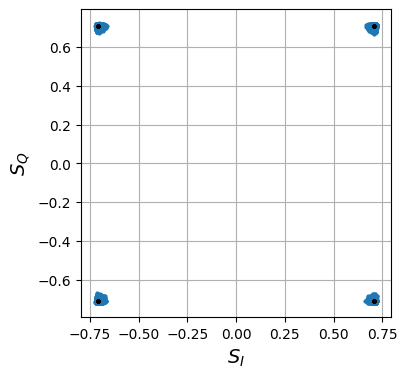

In [36]:
plt.figure(figsize=(4,4))
plt.ylabel('$S_Q$', fontsize=14)
plt.xlabel('$S_I$', fontsize=14)
#plt.xlim(-1.1,1.1)
#plt.ylim(-1.1,1.1)
plt.grid()

plt.plot(sigRx[ind].real,sigRx[ind].imag,'.', markersize=4, label='Rx')
plt.plot(symbTx[ind].real,symbTx[ind].imag,'k.', markersize=4, label='Tx');

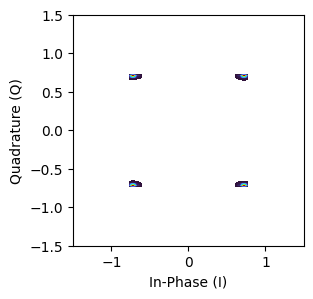

In [37]:
pconst(sigRx[ind],R=1.5);

## Multiplexação de polarização

<img src="./figuras/sistemaCoerentePM.png" width="900">

## Systems WDM coherent

In [39]:
from optic.models.tx import simpleWDMTx

**Geração de signal WDM**

In [40]:
# Parameters of the transmitter:
param = parameters()
param.M   = 16           # ordem do formato de modulation
param.Rs  = 32e9         # rate de sinalização [baud]
param.SpS = 8           # number de amostras por símbolo
param.Nbits = 400000     # number de bits
param.pulse = 'rrc'      # formato de pulso
param.Ntaps = 4096       # number de coefficients do filter RRC
param.alphaRRC = 0.01    # rolloff do filter RRC
param.Pch_dBm = 10        # power média por channel WDM [dBm]
param.Nch     = 5        # number de channels WDM
param.Fc      = 193.1e12 # frequency central do spectrum WDM
param.freqSpac = 40e9    # espaçamento em frequency da grade de channels WDM
param.lw = 0*100e3         # largura de linha dos lasers
param.Nmodes = 1         # number de modes de polarização

sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(param)

  0%|          | 0/5 [00:00<?, ?it/s]

**Transmissão via fibra SMF (split-step Fourier)**

In [43]:
canalLinear = True

# parameters of the channel optical
paramCh = parameters()
paramCh.Ltotal = 800    # km
paramCh.Lspan = 80
paramCh.alpha = 0.2    # dB/km
paramCh.D = 16         # ps/nm/km
paramCh.Fc = 193.1e12  # Hz
paramCh.Fs = Fs  

sigWDM = sigWDM_Tx.copy()
if canalLinear:
    for _ in range(Ltotal//Lspan):       
        sigWDM = linearFiberChannel(sigWDM, paramCh)
        sigWDM = edfa(sigWDM, param.Rs*param.SpS, Lspan*alpha, 4.5, Fc=param.Fc)
else:
    #powerProfile(param.Pch_dBm, alpha, Lspan, Ltotal/Lspan)
    paramCh = parameters()
    paramCh.Ltotal = Ltotal
    paramCh.Lspan = Lspan
    paramCh.alpha = alpha
    paramCh.D = D
    paramCh.Fc = Fc
    paramCh.hz = hz
    paramCh.gamma = gamma
    paramCh.amp = 'edfa'    
    
    sigWDM, paramCh = ssfm(sigWDM_Tx, param.Rs*param.SpS, paramCh) 

TypeError: edfa() got an unexpected keyword argument 'Fc'

**Spectrum dos channels WDM antes e após a transmissão**

In [ ]:
# plota psd
plt.figure()
plt.xlim(Fc-param.SpS*param.Rs/2,Fc+param.SpS*param.Rs/2);
plt.psd(sigWDM_Tx[:,0], Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Tx')
plt.psd(sigWDM, Fs=param.SpS*param.Rs, Fc=Fc, NFFT = 4*1024, sides='twosided', label = 'WDM spectrum - Rx')
plt.legend(loc='lower left')
plt.title('Espectro óptico dos canais WDM');

**Recepção dos channels WDM**

In [ ]:
from optic.plot import constHist

radius = 1.5
cmap = 'turbo'
whiteb = 'False'

### Receiver

# parameters
chIndex = 2 # index do channel a ser demodulado
plotPSD = True

Fa = param.SpS*param.Rs
Ta = 1/Fa

print('Demodulando canal #%d , fc: %.4f THz, λ: %.4f nm'\
      %(chIndex, (Fc + paramTx.freqGrid[chIndex])/1e12, const.c/(Fc + paramTx.freqGrid[chIndex])/1e-9))

sigWDM = sigWDM.reshape(len(sigWDM),)
symbTx = symbTx_[:,:,chIndex].reshape(len(symbTx_),)



# parameters of the oscilador local:
FO      = 128e6                 # desvio de frequency
Δf_lo   = paramTx.freqGrid[chIndex]+FO  # downshift channel a ser demodulado
lw      = 0*100e3                 # largura de linha
Plo_dBm = 10                    # power em dBm
Plo     = 10**(Plo_dBm/10)*1e-3 # power em W
ϕ_lo    = 0                     # phase initial em rad     

print('Oscilador local P: %.2f dBm, lw: %.2f kHz, FO: %.2f MHz'\
      %(Plo_dBm, lw/1e3, FO/1e6))

# gera signal do oscilador local
π       = np.pi
t       = np.arange(0, len(sigWDM))*Ta
ϕ_pn_lo = phaseNoise(lw, len(sigWDM), Ta)
sigLO   = np.sqrt(Plo)*np.exp(1j*(2*π*Δf_lo*t + ϕ_lo + ϕ_pn_lo))

# optical receiver coherent
sigRx = coherentReceiver(sigWDM, sigLO)


# filtragem Rx

# filter casado
if param.pulse == 'nrz':
    pulse = pulseShape('nrz', param.SpS)
elif param.pulse == 'rrc':
    pulse = pulseShape('rrc', param.SpS, N=param.Ntaps, alpha=param.alphaRRC, Ts=1/param.Rs)

pulse = pulse/np.max(np.abs(pulse))            
sigRx = firFilter(pulse, sigRx)

# plota psd
if plotPSD:
    plt.figure();
   # plt.ylim(-250,-50);
    plt.psd(sigRx, Fs=Fa, NFFT = 16*1024, sides='twosided', label = 'Espectro do sinal recebido')
    plt.legend(loc='upper left');
    plt.xlim(-Fa/2,Fa/2);


fig = plt.figure(figsize=(15,4.5))
fig.suptitle('Sequência de processamentos no domínio digital')
ax = fig.add_subplot(1, 4, 1, projection='scatter_density')
ax = constHist(pnorm(sigRx), ax, radius, cmap, whiteb)
ax.title.set_text('Saída do front-end coerente')
ax.set_aspect('equal', 'box')
ax.set_xlim(-2*radius, 2*radius)
ax.set_ylim(-2*radius, 2*radius)
ax.set_xlabel("In-Phase (I)")
ax.set_ylabel("Quadrature (Q)")

# digital backpropagation
# hzDBP = 5
# Pin   = 10**(param.Pch_dBm/10)*1e-3
# sigRx = sigRx/np.sqrt(signal_power(sigRx))
# sigRx = dbp(np.sqrt(Pin)*sigRx, Fa, Ltotal, Lspan, hzDBP, alpha, -gamma, D, Fc)
# sigRx = sigRx.reshape(len(sigRx),)
# sigRx = firFilter(pulse, sigRx)


# compensação dispersion cromática
sigRx = edc(sigRx, Ltotal, D, Fc-Δf_lo, Fa)

# captura uma amostra a cada intervalo de sinalização

# downsampling
paramDec = parameters()
paramDec.SpS_in = param.SpS
paramDec.SpS_out = 1
sigRx = decimate(sigRx.reshape(-1,1), paramDec)

discard = 2000
ind = np.arange(discard, sigRx.size-discard)

# normaliza símbolos recebidos
sigRx = pnorm(sigRx)

# plota constellation após compensação da dispersion cromática
ax = fig.add_subplot(1, 4, 2, projection='scatter_density')
ax = constHist(sigRx[ind], ax, radius, cmap, whiteb)
ax.title.set_text('Após CD comp.')
ax.set_aspect('equal', 'box')
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_xlabel("In-Phase (I)")
#ax.set_ylabel("Quadrature (Q)")

# calcula atraso gerado pelo walkoff
symbDelay = np.argmax(signal.correlate(np.abs(symbTx).reshape(-1,1), np.abs(sigRx)))-sigRx.size+1 

# compensa atraso do walkoff
sigRx = np.roll(sigRx, symbDelay)

# normaliza constellation recebida
sigRx = pnorm(sigRx)

# estima e compensa desvio de frequency entre signal e LO
sigRx, FO_est = fourthPowerFOE(sigRx.reshape(-1,1), param.Rs, plotSpec=False)
print('FO estimado: %3.4f MHz'%(FO_est/1e6))

# plota constellation após compensação do desvio de frequency entre signal e LO
ax = fig.add_subplot(1, 4, 3, projection='scatter_density')
ax = constHist(sigRx[ind], ax, radius, cmap, whiteb)
ax.title.set_text('Após CFR (4th-power FOE)')
ax.set_aspect('equal', 'box')
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_xlabel("In-Phase (I)")
#ax.set_ylabel("Quadrature (Q)")

# compensa noise de phase
paramCPR = parameters()
paramCPR.alg = 'ddpll'
paramCPR.M   = paramTx.M
paramCPR.constType = 'qam'
paramCPR.tau1 = 1/(2*np.pi*10e3)
paramCPR.tau2 = 1/(2*np.pi*10e3)
paramCPR.Kv  = 0.1
#paramCPR.pilotInd = np.arange(0, len(sigRx), 25)

sigRx, θ = cpr(sigRx, symbTx=symbTx.reshape(-1,1), paramCPR=paramCPR)

# plota outputs do estimador de phase
plt.figure()
plt.title('Phase estimada')
plt.plot(θ,'-')
plt.xlim(0, len(θ))
plt.grid();

# corrige (possible) ambiguidade de phase adicionada ao signal
symbRx = symbolSync(sigRx, symbTx.reshape(-1,1), 1)
rot = np.mean(pnorm(symbRx[ind])/sigRx[ind])
sigRx  = rot*sigRx

# normaliza símbolos recebidos
sigRx = pnorm(sigRx)

# plota constellation após compensação do noise de phase
ax = fig.add_subplot(1, 4, 4, projection='scatter_density')
ax = constHist(sigRx[ind], ax, radius, cmap, whiteb)
ax.set_aspect('equal', 'box')
ax.title.set_text('Após CPR (DD-PLL)')
ax.set_xlim(-radius, radius)
ax.set_ylim(-radius, radius)
ax.set_xlabel("In-Phase (I)")
#ax.set_ylabel("Quadrature (Q)")

#fig.tight_layout()

# estima SNR da constellation recebida
SNR = signal_power(symbRx[ind])/signal_power(sigRx[ind]-symbRx[ind])

# Demodulation com aplicação a regra de decisão brusca  
constSymb = GrayMapping(M, 'qam')
Es = np.mean(np.abs(constSymb) ** 2)

sigRx = sigRx.reshape(-1,)
symbRx = symbRx.reshape(-1,)

bitsRx = demodulateGray(np.sqrt(Es)*pnorm(sigRx), M, 'qam') 
bitsTx = demodulateGray(np.sqrt(Es)*pnorm(symbRx), M, 'qam') 

err = np.logical_xor(bitsRx[discard:bitsRx.size-discard], 
                     bitsTx[discard:bitsTx.size-discard])
BER = np.mean(err)

print('SNR[est] = %.2f dB \n'%(10*np.log10(SNR)))
print('Total de bits = %d  '%(err.size))
print('Total de erros contados = %d  '%(err.sum()))
print('BER = %.2e  '%(BER))

plt.figure()
plt.plot(err,'o', label = 'erros')
plt.legend()
plt.grid()

In [ ]:
# def dbp(Ein, Fs, Ltotal, Lspan, hz=0.5, alpha=0.2, gamma=1.3, D=16, Fc=193.1e12):      
#     '''
#     Digital backpropagation (symmetric, single-pol.)
       
#     '''             
#     c = 299792458   # speed of light (vacuum)
#     c_kms = c/1e3
#     λ  = c_kms/Fc
#     α  = -alpha/(10*np.log10(np.exp(1)))
#     β2 = (D*λ**2)/(2*np.pi*c_kms)
#     γ  = gamma
            
#     Nfft = len(Ein)

#     ω = 2*np.pi*Fs*fftfreq(Nfft)
    
#     Nspans = int(np.floor(Ltotal/Lspan))
#     Nsteps = int(np.floor(Lspan/hz))   
        
#     Ech = Ein.reshape(len(Ein),)    
#     Ech = fft(Ech) #single-polarization field    
    
#     linOperator = np.exp(-(α/2)*(hz/2) + 1j*(β2/2)*(ω**2)*(hz/2))
        
#     for spanN in tqdm(range(0, Nspans)):
        
#         Ech = Ech*np.exp((α/2)*Nsteps*hz)
                
#         for stepN in range(0, Nsteps):            
#             # First linear step (frequency domain)
#             Ech = Ech*linOperator            
                      
#             # Nonlinear step (time domain)
#             Ech = ifft(Ech)
#             Ech = Ech*np.exp(1j*γ*(Ech*np.conj(Ech))*hz)
            
#             # Second linear step (frequency domain)
#             Ech = fft(Ech)       
#             Ech = Ech*linOperator             
                
#     Ech = ifft(Ech) 
       
#     return Ech.reshape(len(Ech), 1)

In [ ]:
def powerProfile(Pin, alpha, Lspan, Nspans):
    
    L = np.linspace(0, Nspans*Lspan, 2000)
    
    power = Pin-alpha*(L%Lspan)
    
    plt.plot(L, power,'')
    plt.xlabel('L [km]')
    plt.ylabel('power [dBm]')
    plt.title('Power profile')
    plt.grid()
    plt.xlim(min(L), max(L))

In [ ]:
powerProfile(10, 0.2, 80, 10)